### **Chain**

Building up a simple **chain** that combines 4 key concepts:
* Using chat messages in our graph
* Using chat models
* Biding tools to our LLM
* Executing tool calls in our graph

##### **Messages**

Chat models can use `messages`, which capture different roles within a conversation.

LangChain supports various messages types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`.

These represent a message from user, chat model, for the chat model to instruct behavior, and from a tool call.

Let's create a list of messages. Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, who is creating the message
* `response_metadata` - optionally, a dict of metadata that is often specific to each model provider

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

messages = [AIMessage(content=f'So you said you were researching ocean mammals?', name='Model')]
messages.extend([HumanMessage(content=f"Yes, that's right.", name='Lance')])
messages.extend([AIMessage(content=f'Great, what would you like to learn aboyut?', name='Model')])
messages.extend([HumanMessage(content=f'I want to learn about the best places to see Orcas in the US.', name='Lance')])

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn aboyut?
================================ Human Message =================================
Name: Lance

I want to learn about the best places to see Orcas in the US.


##### **Chat Models**

Chat models can use a sequence of message as input and support message roles.

There are many to choose from!

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [3]:
result.pretty_print()

================================== Ai Message ==================================

Orcas, also known as killer whales, can be seen in several locations along the U.S. coast. Here are some of the best places to observe them:

1. **San Juan Islands, Washington**: This region is one of the best places to see orcas, particularly during the summer months. The resident pods, particularly the Southern Resident killer whales, are often spotted in this area.

2. **Puget Sound, Washington**: Similar to the San Juan Islands, Puget Sound is an excellent location for orca watching. Several boat tours operate here that specialize in whale watching.

3. **Victoria, British Columbia**: While technically in Canada, it’s very close to the U.S. border and is a popular destination for whale watchers from the U.S. The waters around Vancouver Island are home to orcas.

4. **Southern California**: Although less common, orcas can occasionally be seen off the coast of Southern California, particularly around th

In [4]:
result.response_metadata

{'token_usage': {'completion_tokens': 330,
  'prompt_tokens': 69,
  'total_tokens': 399,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-mini-2024-07-18',
 'system_fingerprint': 'fp_0392822090',
 'id': 'chatcmpl-BPBkqGQhGABlYs6zK1g3jyVpMoRfQ',
 'finish_reason': 'stop',
 'logprobs': None}

##### **Tools**

Tools are need whenever you want a model to control parts of your code or call out to external APIs.

Many LLMs providers supports tool calling.

The tool calling interface in LangChain is simple.

You can pass any Python function into `ChatModel.bind_tools()`.

In [5]:
def multiply(a:int, b:int) -> int:
    """Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [9]:
tool_call = llm_with_tools.invoke([HumanMessage(content="What is 2 multipled by 3", name="Lucas")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nKqYhVOwNg0Yciizodk3lcNv', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 69, 'total_tokens': 87, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_dbaca60df0', 'id': 'chatcmpl-BPCrY2oiomyKtLoK0ISmlUUKZvVg1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b9066978-9591-41dd-bbe5-8cebb9fda59a-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_nKqYhVOwNg0Yciizodk3lcNv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 69, 'output_tokens': 18, 'total_tokens': 87, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_d

In [8]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_rlylhJKEchpOE9qKPfC1Y5FR',
  'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
  'type': 'function'}]

##### **Using messages as state**

With these foundations in place, we can now use `messages` in our graph state.

Let's define our state `MessagesState`.

It's defined as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of type `AntMessage`, meaning it's a list of messages.

In [10]:
from typing import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

##### **Reducers**

Now, we have a minor problem!

As graph runs, we want to append messages to our `messages` state key.

But each node will also override the prior state value.

**Reducer functions** address this.

They allow us to specify how state updates are performed.

If no reducer function is explcitly specifeid, then it is assumed that all updates to that key should *override* it.

Since we want to append messages, we can user a pre-built `add_messages` reducer!

This ensures that state updates you send to the graph are appended to the existing list of messages.

We annotate (via `Annotated`) our key with a reducer function as metadata.

In [17]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in your state is so common, LangGraph has a pre-built `MessagesState`!

`MessagesState` is defined:

* With a pre-build single `messages` key
* Which is a list of `AnyMessage` objects and uses the `add_messages` reducer

In [18]:
from langgraph.graph import MessagesState

class State(MessagesState):
    # add any keys needed beyond messages, which is pre-built
    pass

The `MessagesState` and `State` both work equivalently!

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [19]:
# initial state
initial_messages = [AIMessage(content='Hello! How can I assist you?', name='Model'),
                    HumanMessage(content="I'm looking for information on marine biology.", name='Lucas')]

# new messsage to add
new_message = AIMessage(content='Sure, I can help with that. What specifically are you interested in?', name='Model')

# test
add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='02589141-33f6-4ee0-bef0-11e756793447'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lucas', id='1ce83c6b-730f-4fdc-9631-96c40cbe1df2'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='159bcd36-38e5-4ecc-98f0-5f857999102a')]

##### **Our graph**

Now, let's use `MessagesState` with a graph

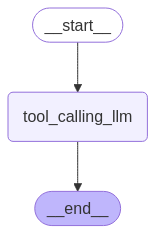

In [21]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# state
class MessagesState(MessagesState):
    # add any keys needed beyond messages, which is pre-built
    pass

# node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

# build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# view
display(Image(graph.get_graph().draw_mermaid_png()))


Here, the LLM responds normally without any tool calls.

In [23]:
messages = graph.invoke({"messages": HumanMessage(content="Hello AI!")})
messages

{'messages': [HumanMessage(content='Hello AI!', additional_kwargs={}, response_metadata={}, id='965ffcff-e9e4-4938-8a69-5ed1370fcb5b'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 61, 'total_tokens': 72, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BPELRELAYxPzqWr1CIzjtDj4jKoql', 'finish_reason': 'stop', 'logprobs': None}, id='run-c336f198-f538-4bb0-9a5c-94756094088d-0', usage_metadata={'input_tokens': 61, 'output_tokens': 11, 'total_tokens': 72, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

Now, we can see that a tool call is performed if our input is related to the tool

In [24]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3!")})
messages

{'messages': [HumanMessage(content='Multiply 2 and 3!', additional_kwargs={}, response_metadata={}, id='74cc31e0-ea4d-4a8a-8c61-b28db5a4e4f2'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xlCGfYd22rSEBxVFgsBMhJUz', 'function': {'arguments': '{"a":2,"b":6}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 65, 'total_tokens': 83, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BPEQEzlatoCFS6Yr8yRk8C3c9hGWJ', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-876df83e-c5c9-4110-a772-a3a4a8cbbab9-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 6}, 'id': 'call_xlCGfYd22rSEBxVFgsBMhJUz', 'type': 'tool_call'}], 